In [1]:
import sys
sys.path.append("C:/Users/cnava/Repos/PolaPy")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

from polapy.competitiveness import blais_lago, grofman_selb, election_competitiveness
from polapy.polarization import election_polarization, esteban_ray
PYTHONWARNINGS="ignore"

from sklearn.model_selection import StratifiedKFold

In [2]:
class ElectionAgent(Agent):
    """ An agent in an election model."""
    def __init__(self, unique_id, model, candidates, p):
        super().__init__(unique_id, model)
        self.choice = np.random.choice(candidates, 1, p=p)

    def step(self):
        pass

class ElectionModel(Model):
    def __init__(self, N=1000, candidates=["A"], p=[1], width=10, height=10) -> None:
        self.num_agents = N
        self.n_candidates = len(candidates)
        self.candidates = candidates
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)

        for i in range(self.num_agents):
            a = ElectionAgent(i, self, candidates=candidates, p=p)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})
        
    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()

In [3]:
candidates = ["A", "B"]
output = []
e_id = 1
for election_id, p in enumerate([
    ([0.5, 0.5]),
    ([0.6, 0.4]),
    ([0.7, 0.3]),
    ([0.8, 0.2]),
    ([0.9, 0.1]),
    ([1.0, 0.0])
]):
    for iteration in range(30):
        model = ElectionModel(N=1000, candidates=candidates, p=p)
        model.step()

        df = pd.DataFrame([x.choice for x in model.schedule.agents], columns=["candidate"])
        df["votes"] = 1
        df["election_id"] = e_id
        e_id += 1

        if iteration % 2 == 0:
            df = df.sort_values("candidate")

        for i, frag in enumerate(np.array_split(df, 10)):
            frag["unit"] = i + 1
            output.append(frag)

data = pd.concat(output, ignore_index=True)
data = data.groupby(["election_id", "unit", "candidate"]).agg({"votes": "sum"}).reset_index()
data.head()


,election_id,unit,candidate,votes
0,1,1,A,100
1,1,2,A,100
2,1,3,A,100
3,1,4,A,100
4,1,5,A,100


In [4]:
total = data.groupby(["election_id", "candidate"]).agg({"votes": "sum"})
total["share"] = total.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
total = total.unstack().reset_index(drop=False).fillna(0)
total.columns = ["election_id", "votes.A", "votes.B", "share.A", "share.B"]
total["margin"] = 1 - np.abs(total["share.A"] - total["share.B"])
total.head()

,election_id,votes.A,votes.B,share.A,share.B,margin
0,1,513.0,487.0,0.513,0.487,0.974
1,2,510.0,490.0,0.510,0.490,0.980
2,3,523.0,477.0,0.523,0.477,0.954
3,4,508.0,492.0,0.508,0.492,0.984
4,5,499.0,501.0,0.499,0.501,0.998


In [5]:
output = []
for idx, frag in data.groupby("election_id"):
    value, antagonisms = election_competitiveness(frag, candidate="candidate", votes="votes")
    output.append({
        "ec": value,
        "election_id": idx
    })

df_competitiveness = pd.DataFrame(output)
df_competitiveness.head()

C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum(

,ec,election_id
0,0.026518,1
1,0.859974,2
2,0.047243,3
3,0.944029,4
4,0.002004,5


In [6]:
df_comparison = pd.merge(
    total[["election_id", "margin"]],
    df_competitiveness[["election_id", "ec"]], 
    on="election_id"
)

df_comparison.head()

,election_id,margin,ec
0,1,0.974,0.026518
1,2,0.980,0.859974
2,3,0.954,0.047243
3,4,0.984,0.944029
4,5,0.998,0.002004


<AxesSubplot: xlabel='margin', ylabel='ec'>

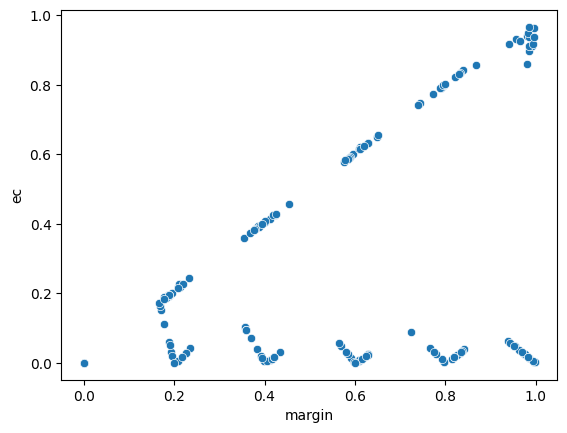

In [7]:
sns.scatterplot(x="margin", y="ec", data=df_comparison)

KeyError: 'xx'

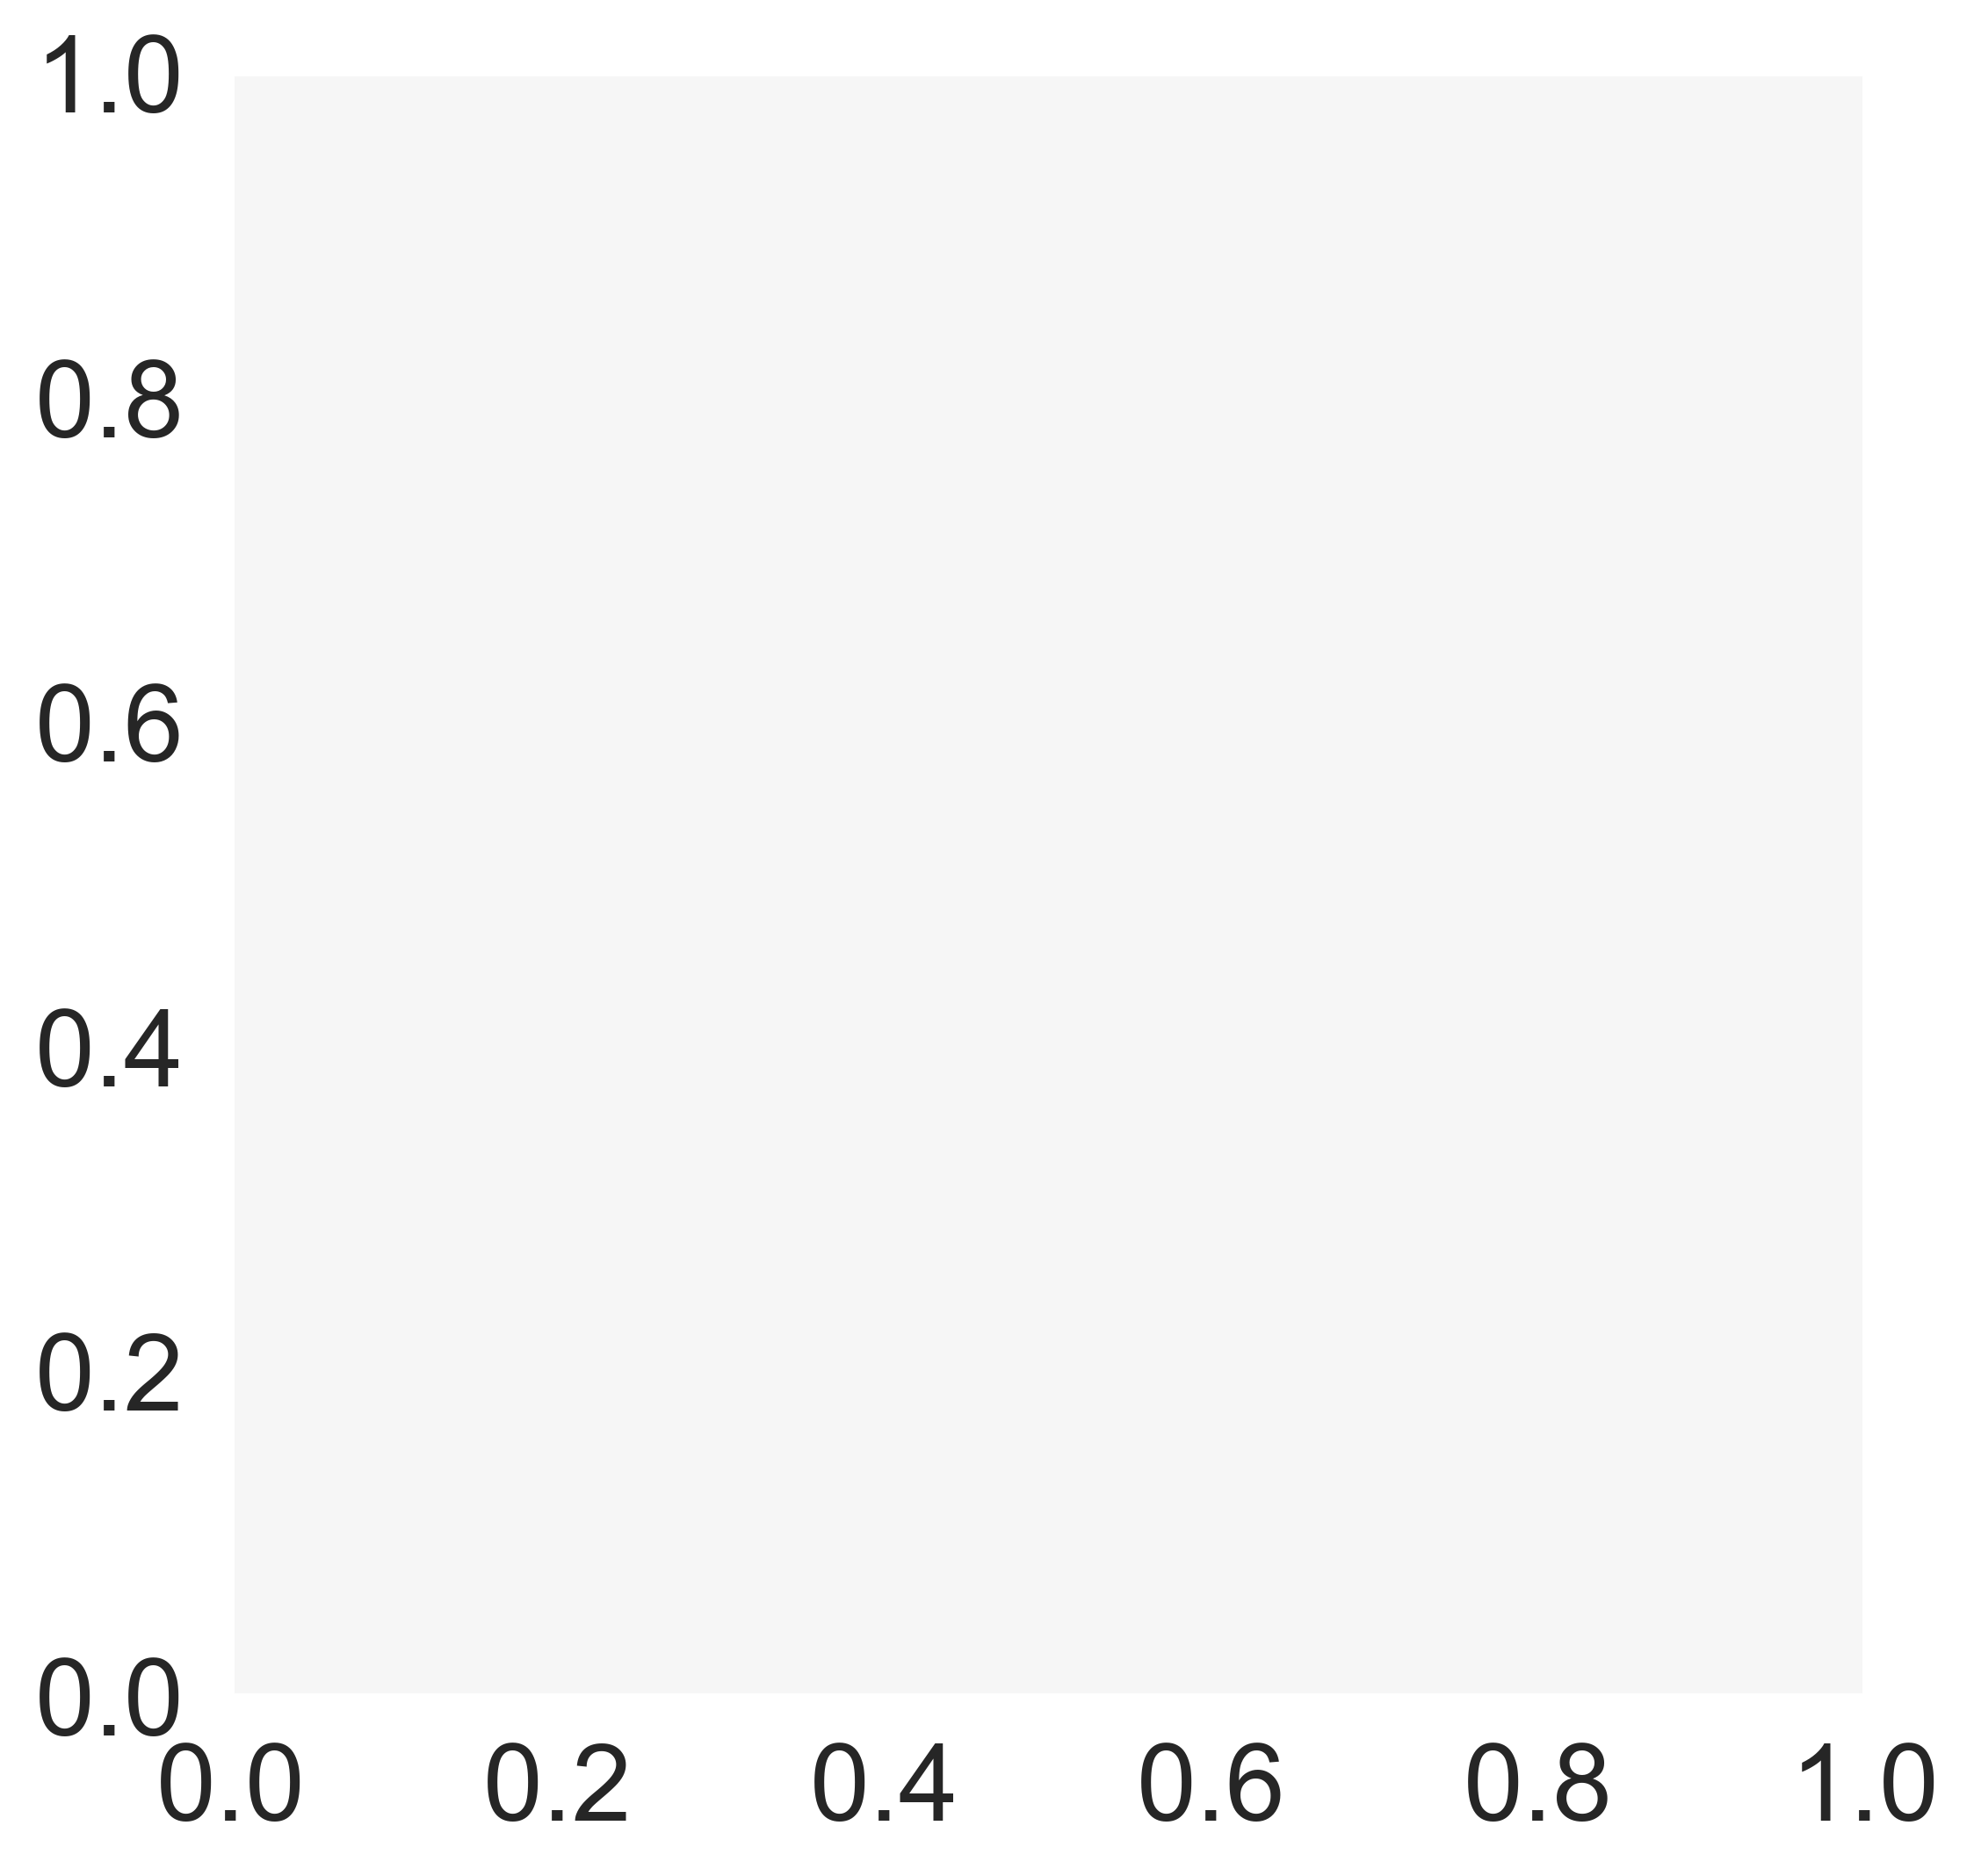

In [8]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, ax = plt.subplots(figsize=(6, 6), dpi=400)

ax = sns.boxplot(
    y="yy",
    x="value",
    hue="sigma",
    showfliers=False,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "Between-EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))]
)

# plt.xticks(rotation=90)
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.remove()
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("")

In [ ]:
election_competitiveness(data, candidate="candidate", votes="votes")

(0.6019664685354237,
   candidate  antagonism
 0         A    0.217992
 1         B    0.233753
 2         C    0.150221)

In [ ]:
data = df.groupby("candidate").agg({"votes": "sum"}).reset_index()
data["share"] = data["votes"] / data["votes"].sum()

data

,candidate,votes,share
0,A,978,0.0978
1,B,1997,0.1997
2,C,7025,0.7025


(0.6019664685354237,
   candidate  antagonism
 0         A    0.217992
 1         B    0.233753
 2         C    0.150221)